## TP5

In [1]:
# Importamos las librerías necesarias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Versión seleccionando la ROI

ROI seleccionada:
finish


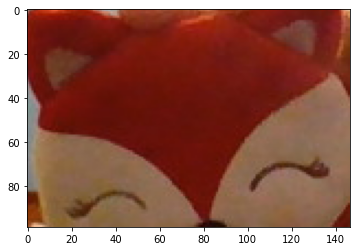

In [42]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
term_crit = ( cv.TERM_CRITERIA_COUNT | cv.TERM_CRITERIA_EPS, 10, 1 )

font = cv.FONT_HERSHEY_SIMPLEX

camera = cv.VideoCapture(0)

# track_window_selected = (x, y, w, h)
twindow = (0, 0, 0, 0)
startPoint = False
endPoint = False
twindowCreated = False

def createROI(twindow, frame):
    x, y, w, h = twindow
    # Una vez definida la ROI recortamos esa parte de la imagen que utilizaremos para seguimiento
    #--------------------------------------------------------------------------------------------
    roi = frame[y:y+h, x:x+w]
    rgb_roi = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
    # Pasamos la ROI a HSV (los valores de H son más estables a cambios de intensidad)
    hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    # Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
    mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
    # Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
    roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
    # Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
    cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

    # Mostramos lo que se fue armando en relación a la ROI
    #-----------------------------------------------------
    print('ROI seleccionada:')
    plt.figure()
    plt.imshow(rgb_roi)
    return roi_hist
        

def selecROI(event, x, y, flags, param):
    global frame, twindow, startPoint, endPoint
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(frame, (x,y), 4, (0, 255, 0), 2)
        cv.imshow("frame", frame)
        
        if startPoint == False:
            twindow = (x, y, 0, 0)
            startPoint = True
        elif endPoint == False:
            twindow = (twindow[0], twindow[1], abs(x-twindow[0]), abs(y-twindow[1]))
            endPoint = True   

roi_hist = None
            
while(1):
    ret ,frame = camera.read()
    cv.namedWindow('frame')
    cv.setMouseCallback('frame', selecROI)
    
    if endPoint == True and twindowCreated == False:
        roi_hist = createROI(twindow, frame)
        twindowCreated = True
    
    if cv.waitKey(33) == ord('e'):
        print("finish")
        break
    
    if roi_hist is None:
        cv.putText(frame, 'Selec 2puntos/esquinas crear ROI', (10,50), font, 1, (0, 255, 0), 2, cv.LINE_AA)
        cv.imshow('frame',frame)
    else:
        # Pasamos el nuevo frame a HSV
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)        
        # Calculamos la proyección inversa del histograma
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
               
        ret, twindow = cv.meanShift(dst, twindow, term_crit)       
        #ret, twindow = cv.CamShift(dst, track_window, term_crit)
        x,y,w,h = twindow
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        
        cv.imshow('frame',img2)
        
cv.destroyAllWindows()
camera.release()

## Version desde video pre grabado

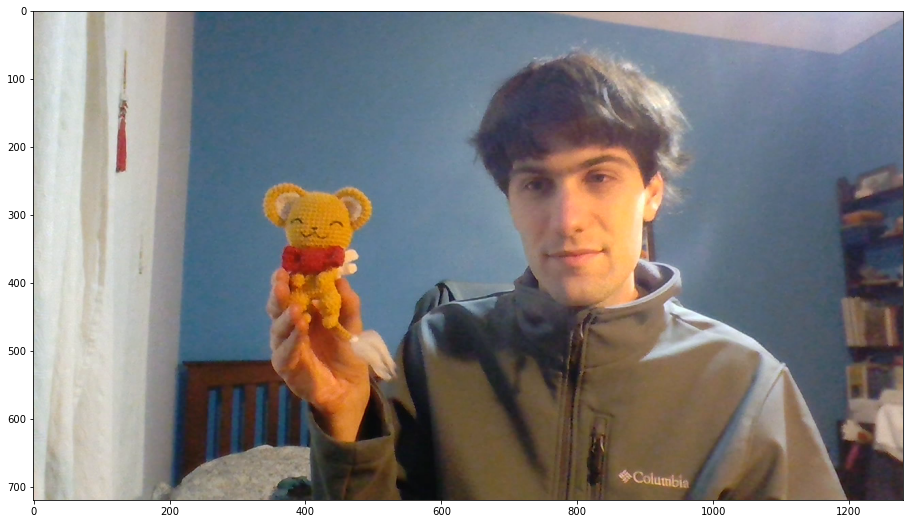

In [31]:
# Puntero al video
cap = cv.VideoCapture('hernan_video.mp4')

# Tomamos el primer frame del video (donde vamos a definir la ROI)
#-----------------------------------------------------------------
ret,frame = cap.read()
# Muestro la imagen como para ver dónde definimos la ROI
#-------------------------------------------------------
rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.imshow(rgb_frame)

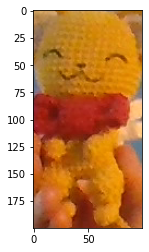

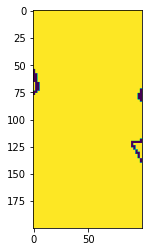

In [32]:
# Definimos la ubicación inical de la ventana de seguimiento
#-----------------------------------------------------------
# r,h,c,w - Región de la imagen (valores harcodeados)
x, y, w, h = 370, 270, 100, 200
track_window = (x, y, w, h)

# Una vez definida la ROI recortamos esa parte de la imagen que utilizaremos para seguimiento
#--------------------------------------------------------------------------------------------
roi = frame[y:y+h, x:x+w]
rgb_roi = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
# Pasamos la ROI a HSV (los valores de H son más estables a cambios de intensidad)
hsv_roi =  cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# Definimos una máscara para el histograma (Hue: 0..180, Saturation:60..255, Value:32..255)
mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
# Y calculamos el histograma sobre esa máscara (toma solo el Hue: tonalidad)
roi_hist = cv.calcHist([hsv_roi],[0],mask,[180],[0,180])
# Normalizamos el histograma (entre 0 y 255 según indica el flag cv.NORM_MINMAX)
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)

# Mostramos lo que se fue armando en relación a la ROI
#-----------------------------------------------------
plt.figure()
plt.imshow(rgb_roi)

# Mostramos lo que se fue armando en relación a la ROI
#-----------------------------------------------------
plt.figure()
plt.imshow(mask)

In [33]:
# Condición de terminación: 10 iteraciones o moverse al menos 1pt
#----------------------------------------------------------------
term_crit = ( cv.TERM_CRITERIA_COUNT | cv.TERM_CRITERIA_EPS, 10, 1 )

cap = cv.VideoCapture('hernan_video.mp4')

while(1):
    # Tomamos un nuevo frame
    #-----------------------
    ret ,frame = cap.read()

    # Mientras haya frames procesamos
    #--------------------------------
    if ret == True:
        # Pasamos el nuevo frame a HSV
        #-----------------------------
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        
        # Calculamos la proyección inversa del histograma
        #------------------------------------------------
        dst = cv.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # En términos probabilísticos, esto es la probabilidad que un píxel corresponda a los
        # valores rescatados en el histograma de la imagen de testeo
        # "La retroproyección es una forma de registrar qué tan bien los píxeles de una imagen
        # dada se ajustan a la distribución de píxeles en un modelo de histograma." 
        # Para la retroproyección, se calcula el modelo de histograma de una característica y 
        # luego se usa para encontrar esta característica en una imagen.
        #
        # NOTAR que busca en toda la imagen
        #
        # Un histograma de imagen mide la distribución de color (y brillo) de los píxeles en una
        # imagen. Si se toma una imagen e se identifica una región de interés, por ejemplo una mano,
        # y se calcula el histograma de los píxeles de ese objeto. Luego, se toma ese histograma y 
        # una segunda imagen y esencialmente se invierte el proceso: se elijen los píxeles en la 
        # segunda imagen que coincidan con el histograma de la primera. Es este proceso inverso el 
        # que le da el nombre de retroproyección. Luego se asume que las áreas de la imagen en la 
        # segunda imagen que tienen la misma distribución de color que un objeto en la primera imagen
        # son una imagen del mismo (o similar) objeto.
        
        # Aplicamos meanshift para encontrar la nueva ubicación (precisa justamente que se le
        # ingrese una retroproyección del histograma del objeto)
        #-------------------------------------------------------
        ret, track_window = cv.meanShift(dst, track_window, term_crit)
        # La función implementa el algoritmo de búsqueda de objetos iterativos. Toma la 
        # retroproyección de entrada de un objeto y la posición inicial. Se calcula el 
        # centro de masa en la ventana de la imagen de retroproyección y el centro de la 
        # ventana de búsqueda se desplaza al centro de masa. El procedimiento se repite 
        # hasta que se completa el número especificado de iteraciones criterios.maxCount 
        # o hasta que el centro de la ventana se desplaza menos que criterios.epsilon.
        #
        # El tamaño o la orientación de la ventana de búsqueda no cambian durante la búsqueda
        #
        # NOTAR que se le pasa como parámetro la ventana de trackeo inicial
        
        # Dibujamos la ventana de seguimiento en la imagen
        #-------------------------------------------------
        x,y,w,h = track_window
        img2 = cv.rectangle(frame, (x,y), (x+w,y+h), 255,2)
        cv.imshow('Seguimiento',img2)

        k = cv.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv.imwrite(chr(k)+".jpg",img2)

    else:
        break

cv.destroyAllWindows()
cap.release()